In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import time

In [96]:
#Computes the cost of OPT
def compute_cost_opt(X):
    n=len(X)
    return np.flip(np.arange(1,n+1))@np.sort(X)

#Computes the cost of Round Robin (RR)
def compute_cost_rr(X):
    n=len(X)
    return (2*np.flip(np.arange(n))+1)@np.sort(X)

#This is the slow, natural implementation of computing the stopping time and the best type in ETC-RR
def stopping_time_slow(jobs_data):
    n=len(jobs_data)//2
    sorted_jobs_data=jobs_data.sort_values(by="job_time")
    m_by_type={}
    m_by_type[1]=0
    m_by_type[2]=0
    m=0
    gap=np.abs(m_by_type[1]-m_by_type[2])
    while gap<=6*np.sqrt(np.max([m_by_type[2],m_by_type[1]])*np.log(n)) and m<2*n:
        if sorted_jobs_data.iloc[m].job_type==1:
            m_by_type[1]+=1
        else:
            m_by_type[2]+=1
        gap=np.abs(m_by_type[1]-m_by_type[2])
        # print(m,gap,6*np.sqrt(np.max([m_by_type[2],m_by_type[1]])*np.log(n)),m_by_type)
        m+=1

    best_type=max(m_by_type, key=m_by_type.get)
    return (best_type,m)

#This is a faster implmentation that takes into account the difference between the threshold and the current gap to do less iterations
def stopping_time(jobs_data):
    n=len(jobs_data)//2
    ind=int(36*np.log(n))-1
    continue_exploration=True
    counts_m_dict={1:0,2:0}
    while continue_exploration and (ind<2*n):
        counts_at_m=jobs_data.iloc[:ind].groupby("job_type").count()
        for row in counts_at_m.iterrows():
            counts_m_dict[row[0]]=row[1].values[0]
        gap=np.abs(counts_m_dict[1]-counts_m_dict[2])
        continue_exploration = (gap<=6*np.sqrt(max(counts_m_dict.values())*np.log(n))) or (max(counts_m_dict.values())<=36*np.log(n))
        # print(ind,continue_exploration,gap,6*np.sqrt(max(counts_m_dict.values())*np.log(n)),counts_m_dict)
        ind=int(np.min([ind+(6*np.sqrt(max(counts_m_dict.values())*np.log(n))-gap),2*n]))+1
        best_type=max(counts_m_dict, key=counts_m_dict.get)
    return (best_type,np.min([ind,2*n]))

In [103]:
#Number of experiments repeat to approximate the expectation
n=10000

#Number of repeated data generations to approximate the expectation 
q=100

cr_etc_list=[]
cr_rr_list=[]
cr_ftp_c_list=[]
cr_ftp_w_list=[]

cost_opt_list=[]

lamb_space=np.linspace(0.01,1,20)

cost_etc_mat=np.zeros((len(lamb_space),q))

for j in range(len(lamb_space)):
    lamb=lamb_space[j]
    scale_x=lamb
    scale_y=1

    if scale_x<scale_y:
        true_best_type=1
    else:
        true_best_type=2

    expected_cost_etc=0
    expected_cost_rr=0
    expected_cost_opt=0
    expected_cost_ftp_correct=0
    expected_cost_ftp_wrong=0

    for i in range(q):

        X=stats.expon.rvs(size=n,scale=scale_x)
        Y=stats.expon.rvs(size=n,scale=scale_y)
        Z=np.concatenate([X,Y])
        jobs_data=pd.DataFrame({"job_time":Z,"job_type":[1]*len(X)+[2]*len(Y)})
        jobs_data.sort_values(by="job_time",inplace=True)

        cost_opt=compute_cost_opt(jobs_data.job_time)
        cost_rr=compute_cost_rr(jobs_data.job_time)

        cost_ftp_wrong=np.flip(np.arange(1,n+1))@X+np.flip(np.arange(1,n+1))@Y+n*np.sum(Y)
        cost_ftp_correct=np.flip(np.arange(1,n+1))@X+np.flip(np.arange(1,n+1))@Y+n*np.sum(X)

        explored_best_type,m_stop=stopping_time(jobs_data)

        cost_exploration=compute_cost_rr(jobs_data.iloc[:m_stop].job_time)\
            +2*(len(jobs_data)-m_stop)*jobs_data.job_time.iloc[:m_stop].sum()\
            +jobs_data.job_time.iloc[m_stop-1]*(len(jobs_data)-m_stop)**2

        #Update for the job parts already already executed
        jobs_data_remaining=jobs_data.copy()
        jobs_data_remaining.job_time=(jobs_data_remaining.job_time-jobs_data.job_time.iloc[m_stop-1]).clip(0)
        jobs_data_remaining=jobs_data_remaining.iloc[m_stop:]

        remaining_best_type=jobs_data_remaining.loc[jobs_data_remaining.job_type==explored_best_type].sort_index()
        remaining_worst_type=jobs_data_remaining.loc[~(jobs_data_remaining.job_type==explored_best_type)].sort_index()

        cost_exploitation=np.flip(np.arange(1,len(remaining_best_type)+1))@remaining_best_type.job_time.values\
            +np.flip(np.arange(1,len(remaining_worst_type)+1))@remaining_worst_type.job_time.values\
            +len(remaining_worst_type)*remaining_best_type.job_time.sum()

        cost_etc=cost_exploration+cost_exploitation

        cost_etc_mat[j,i]=cost_etc

        expected_cost_etc+=cost_etc/q
        expected_cost_rr+=cost_rr/q
        expected_cost_opt+=cost_opt/q
        expected_cost_ftp_correct+=cost_ftp_correct/q
        expected_cost_ftp_wrong+=cost_ftp_wrong/q
            
    cost_opt_list.append(expected_cost_opt)

    cr_etc_list.append(expected_cost_etc/expected_cost_opt)
    cr_rr_list.append(expected_cost_rr/expected_cost_opt)
    cr_ftp_c_list.append(expected_cost_ftp_correct/expected_cost_opt)
    cr_ftp_w_list.append(expected_cost_ftp_wrong/expected_cost_opt)

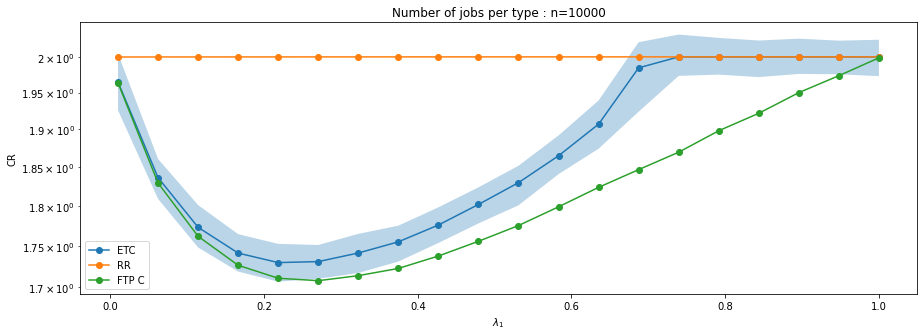

In [106]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.set_title("Number of jobs per type : n="+str(n))
ax.fill_between(lamb_space,np.quantile(cost_etc_mat,0.95,axis=1)/np.array(cost_opt_list),np.quantile(cost_etc_mat,0.05,axis=1)/np.array(cost_opt_list),alpha=0.3)
ax.plot(lamb_space,cr_etc_list,label="ETC",marker="o")
ax.plot(lamb_space,cr_rr_list,label="RR",marker="o")
ax.plot(lamb_space,cr_ftp_c_list,label="FTP C",marker="o")

ax.legend()
ax.set_yscale("log")
ax.set_ylabel("CR")
ax.set_xlabel(r"$\lambda_1$")
plt.savefig("etc_rr_2.pdf")

CR FTP Wrong: 2.854695240472922


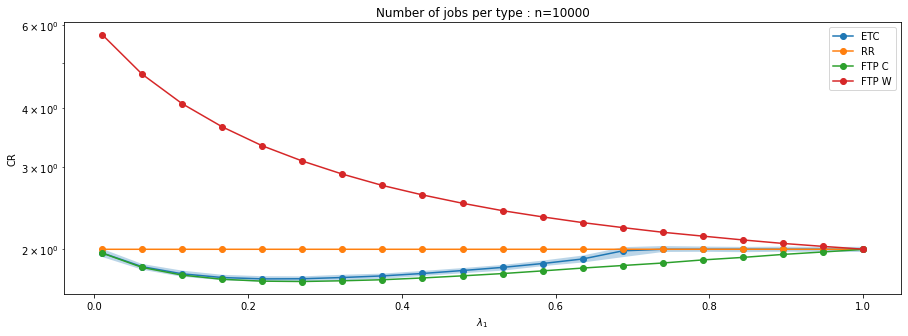

In [108]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.set_title("Number of jobs per type : n="+str(n))
ax.fill_between(lamb_space,np.quantile(cost_etc_mat,0.95,axis=1)/np.array(cost_opt_list),np.quantile(cost_etc_mat,0.05,axis=1)/np.array(cost_opt_list),alpha=0.3)
ax.plot(lamb_space,cr_etc_list,label="ETC",marker="o")
ax.plot(lamb_space,cr_rr_list,label="RR",marker="o")
ax.plot(lamb_space,cr_ftp_c_list,label="FTP C",marker="o")

ax.plot(lamb_space,cr_ftp_w_list,label="FTP W",marker="o")
print("CR FTP Wrong:",np.mean(cr_ftp_w_list))
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("CR")
ax.set_xlabel(r"$\lambda_1$")
plt.savefig("etc_rr_2.pdf")